In [557]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import catboost
pd.options.display.max_rows = None
pd.options.display.max_columns = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Load data
# Loading data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.drop(["Id"],inplace=True,axis=1)
test_id = test.Id
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


## <ins> Removing Outliers

In [558]:
train = train.drop(train['LotFrontage']
                                     [train['LotFrontage']>200].index)
train = train.drop(train['LotArea']
                                     [train['LotArea']>100000].index)
train = train.drop(train['BsmtFinSF1']
                                     [train['BsmtFinSF1']>4000].index)
train = train.drop(train['TotalBsmtSF']
                                     [train['TotalBsmtSF']>6000].index)
train = train.drop(train['1stFlrSF']
                                     [train['1stFlrSF']>4000].index)
train = train.drop(train.GrLivArea
                                     [(train['GrLivArea']>4000) & 
                                      (train.SalePrice<300000)].index)
train = train.drop(train.LowQualFinSF
                                     [train['LowQualFinSF']>550].index)

## Which numeric features have missing values? 

In [559]:
numeric_features = train.select_dtypes(exclude=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = numeric_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = numeric_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')

"MasVnrArea" has 8 missing value(s).
"GarageYrBlt" has 81 missing value(s).
"LotFrontage" has 256 missing value(s).


### We will define GarageYrBlt = NaN as 0, since the house dosen't have garage.
### Same for LotFrontage and MasVnrArea as NaN means no linear feet of street connected to property


In [560]:
train.GarageYrBlt.fillna(0,inplace=True)
train.GarageYrBlt[train.GarageYrBlt == 0] = train.YearBuilt[train.GarageYrBlt == 0]
train.LotFrontage.fillna(0,inplace=True)
train.MasVnrArea.fillna(0,inplace=True)
numeric_features = train.drop(["SalePrice"],axis=1).select_dtypes(exclude=["object"])

C:\Users\yosefos\AppData\Local\Temp\ipykernel_11652\1554693866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.GarageYrBlt[train.GarageYrBlt == 0] = train.YearBuilt[train.GarageYrBlt == 0]


## Cleaning missing values in categorical features

In [561]:
categorical_features = train.select_dtypes(include=["object"])
# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s).')


"Electrical" has 1 missing value(s).
"MasVnrType" has 8 missing value(s).
"BsmtQual" has 37 missing value(s).
"BsmtCond" has 37 missing value(s).
"BsmtFinType1" has 37 missing value(s).
"BsmtExposure" has 38 missing value(s).
"BsmtFinType2" has 38 missing value(s).
"GarageType" has 81 missing value(s).
"GarageFinish" has 81 missing value(s).
"GarageQual" has 81 missing value(s).
"GarageCond" has 81 missing value(s).
"FireplaceQu" has 690 missing value(s).
"Fence" has 1172 missing value(s).
"Alley" has 1361 missing value(s).
"MiscFeature" has 1400 missing value(s).
"PoolQC" has 1446 missing value(s).


### Electrical:  Missing was set to the mode of neighborhood its neighborhood

#### The remainings features  contain NaN values because they represent a qualitative measurement of a property that doesn't exist. For instance, if a row has a value of 0 for 'Fireplaces', then 'FireplaceQu' will also be NaN. To make it easier to work with the data later, I've converted all these NaN values to the string "Na".

In [562]:
# Electricity
most_common_in_neigh = categorical_features[(categorical_features['Neighborhood'] == categorical_features.loc[1379]['Neighborhood'])]["Electrical"].value_counts().index[0]
categorical_features.loc[1379, 'Electrical']  = most_common_in_neigh


## Remaining


# Get a Boolean DataFrame indicating missing values
missing_values = categorical_features.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = categorical_features.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()


for col in columns_with_missing_values: # columns related to garage and basement
    
    categorical_features[col].fillna("Na", inplace=True)


## Splitting data into categorical, continuous and ordinal.

In [563]:
continuous_features = numeric_features[ ['MiscVal',"LotFrontage", 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
                                         'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF','OpenPorchSF','3SsnPorch','EnclosedPorch', 'ScreenPorch', 'PoolArea'] ].copy()

discrete_features = numeric_features[list(set(numeric_features.columns) - set(continuous_features.columns))].copy()

categorical_features["MSSubClass"] = discrete_features.MSSubClass
discrete_features.drop("MSSubClass",axis=1,inplace=True)

categorical_features["MoSold"] = discrete_features.MoSold
discrete_features.drop("MoSold",axis=1,inplace=True)

#### Idea #1 : decide which features in categorical are ordinary in nature, and which aren't. The ideea is to assaign values to ordinary features (like 'OverallCond') and one-hot-enconding to true categorical features.

#### Idea  #2 : remove features where one category has much more counts than the others, making this feature informationless.

#### A drawback to this is that we perhaps loss information about edge cases: this is fine however, as first i am trying to make a simple generic model.



## <ins> Idea 1

### After inspection, the next features were chosen as ordinal features:

##### 'ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
##### 'HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual'


### <ins> Remark: Many of this features has Na in it, which is not strictly ordinal

### We will check if having basement in general is better than having no basement, and if os. we can rank Na as lowest. same for garage

### The general trend is that indeed no garage or basment lowers the price of the house, so we will assign the lowest value to Na 

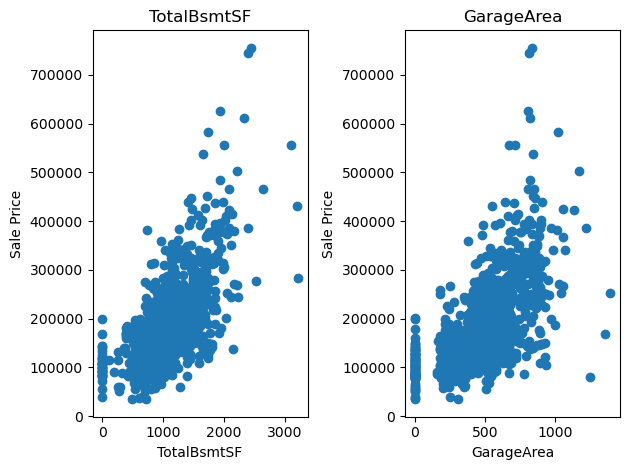

In [564]:
columns = ['TotalBsmtSF','GarageArea']

for i,col in enumerate(columns):
    plt.subplot(1,2,i+1)
    x = numeric_features[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

# Show the plot

plt.tight_layout()

## Change GarageYrBLt = 0 to YearBlt
## Add Bedroom

## Splitting categorical features to ordinal and categorical

In [565]:
columns = ['ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual']
ordinal_features = categorical_features[columns].copy()

categorical_features.drop(columns,axis=1,inplace=True)

mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Na': 0,
    'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,
    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
    'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0,
    'Fin': 3, 'RFn': 2, 'Unf': 1}


for col in columns:
    ordinal_features[col] = ordinal_features[col].map(mapping)


#### Lastly we need to convert features with int dtype to string and to one-hot-encode the categorical data:

In [566]:
int_cols = categorical_features.select_dtypes(include='int').columns
# Change datatype of all integer columns to string
categorical_features[int_cols] = categorical_features[int_cols].astype(str)

# get dummies
one_hot_categorical_features = pd.get_dummies(categorical_features)

## <ins>So far:
#### We have split the data into 4:
1. Continuous data
2. Discrete numerical
3. Oridnal
4. Categorical

## <ins>Looking deeper into discrete feautres:


### Plotting features vs SalePrice

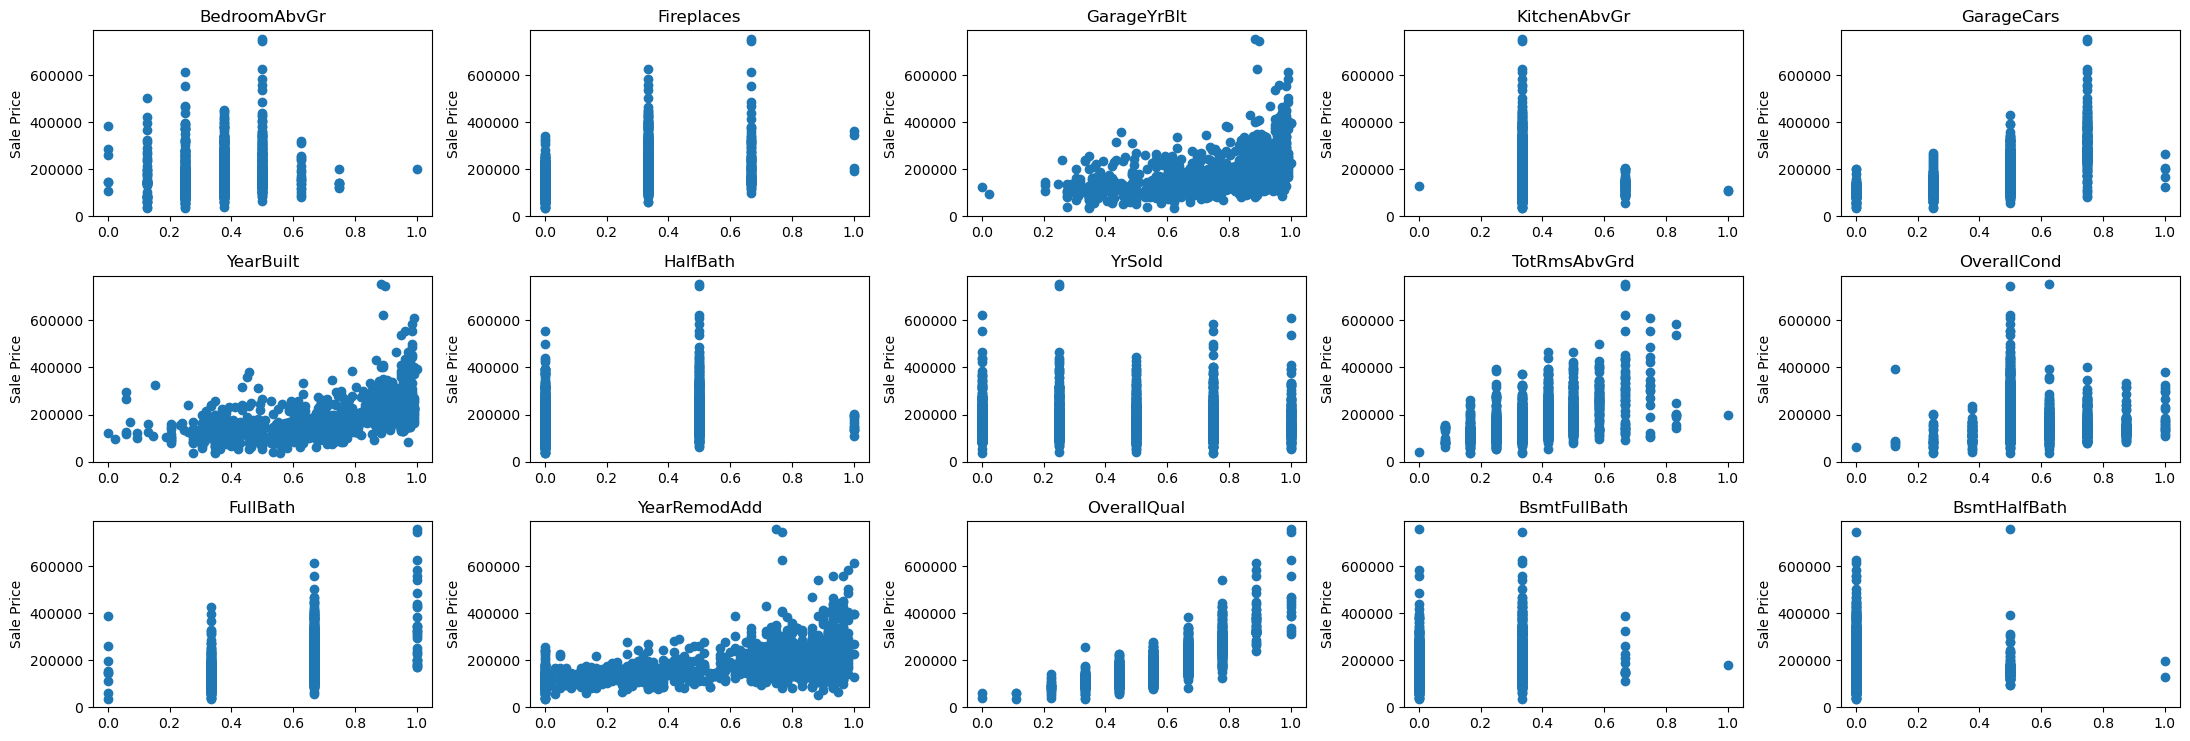

In [567]:
plt.figure(figsize = (22,22))
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(discrete_features),columns=discrete_features.columns)
for i,col in enumerate(scaled_df.columns):

    
    plt.subplot(9,5,i+1)
    
    x = scaled_df[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Sale Price")

    # Show the plot

plt.tight_layout()

## Mean of each discrete value

#### 1. I remove the point GarageYrBlt = 0 because it skews the plot. however it is clear that having no garage predicts low SalePrice. Perhaps it should be treated as the lowest year instead of 0

#### 2. It appears that the finnancial crisis in 2007 drops home prices alot. need to look deeper into that, and make sure it is not because of different counts per year.

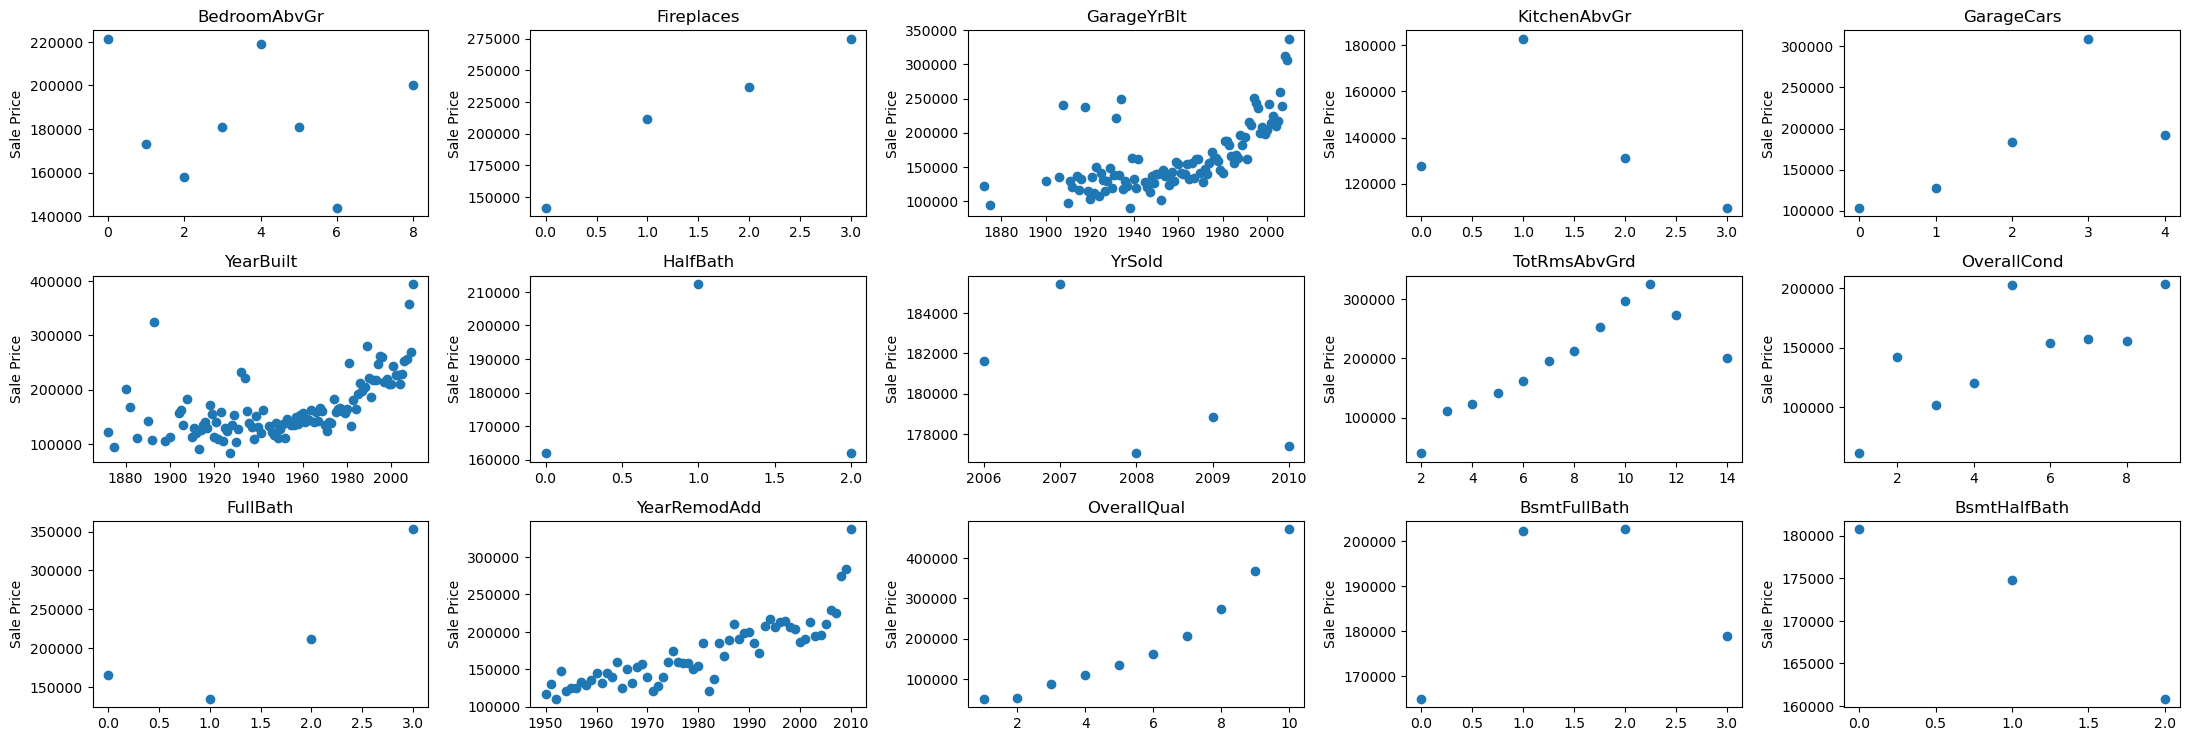

In [568]:
plt.figure(figsize=(22, 22))
scaler = MinMaxScaler()
scaled_df = discrete_features
for i, col in enumerate(scaled_df.columns):
    # if col != 'YearBuilt' and col != 'GarageYrBlt' and col != 'YearRemodAdd':
    plt.subplot(9, 5, i + 1)
    if col == 'GarageYrBlt':
        x = scaled_df[col].unique()
        x = x[x!= 0]
    else:

        x = scaled_df[col].unique()
    y = [train.loc[scaled_df[col] == val, 'SalePrice'].mean() for val in x]
    plt.scatter(x, y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.ylabel("Sale Price")

plt.tight_layout()


## Count of discrete features

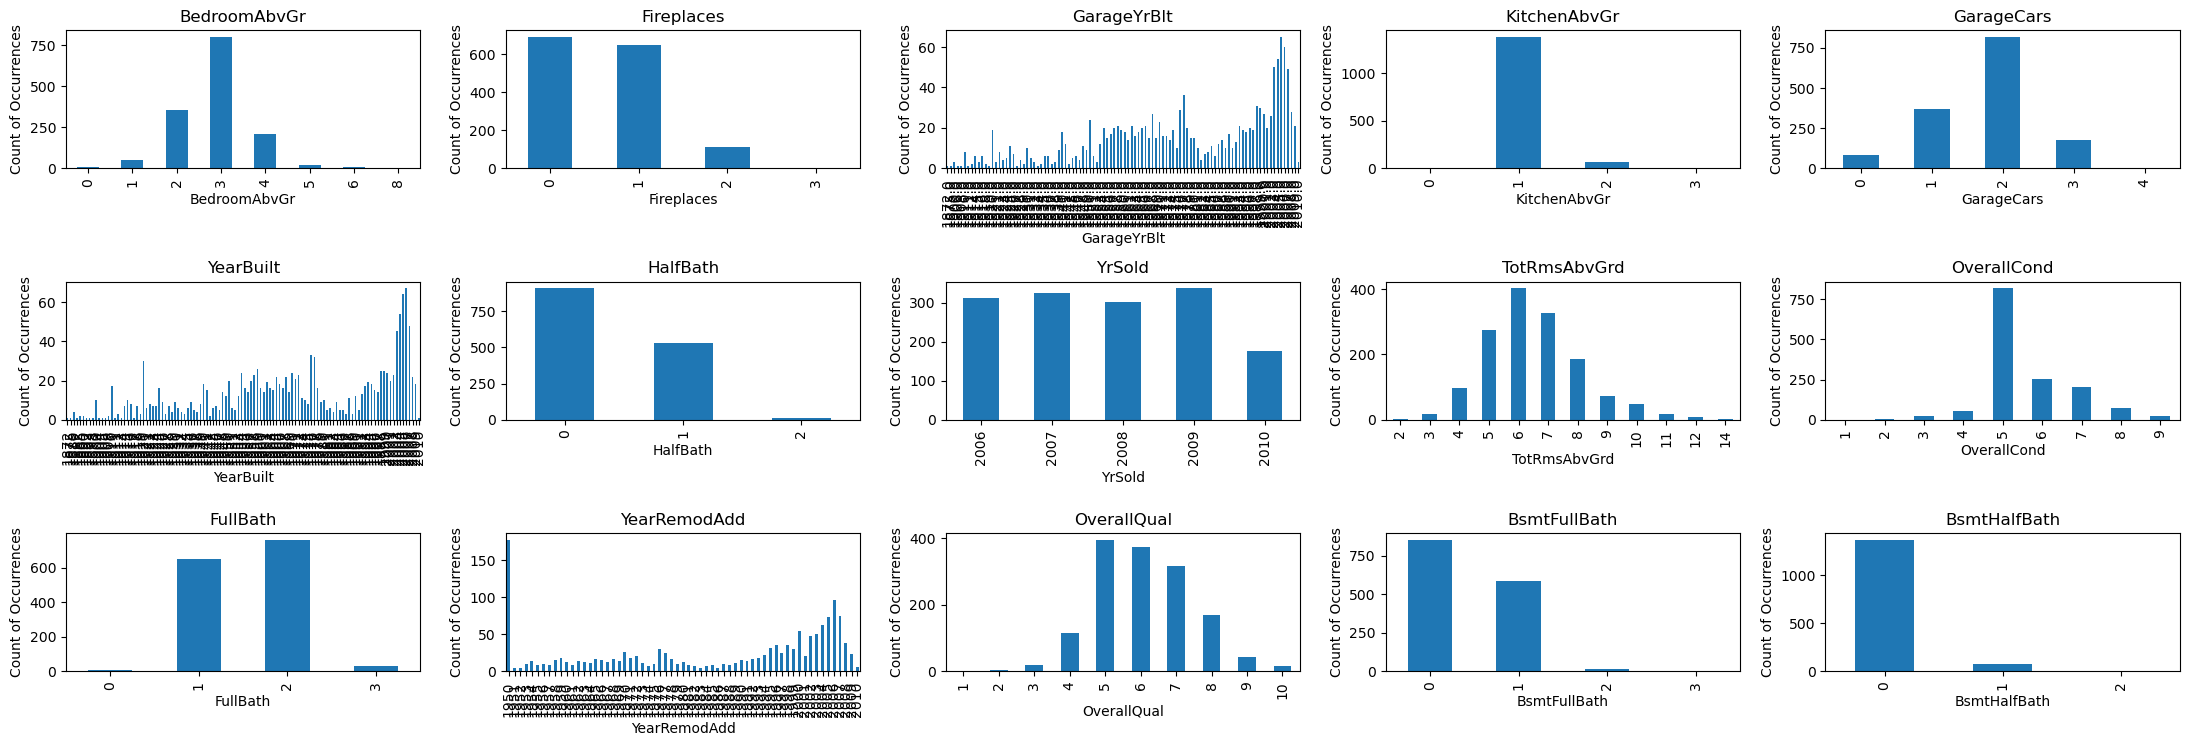

In [569]:

plt.figure(figsize = (22,22))
for i,col in enumerate(discrete_features.columns):
    plt.subplot(9,5,i+1)
    count_by_zoning = discrete_features.groupby(col).size()

    # Sort the count of occurrences in descending order
    

    # Plot the count of occurrences for each group
    count_by_zoning.plot.bar()

    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count of Occurrences")

    # Show the plot

plt.tight_layout()


## <ins> Conclusions:

#### 1. Some features should be moved to ordinal features as they have clear ordinal behavior in respect to SalePrice that is not because of imbalance:
####    ['OverallQual', 'Fireplaces', 'BsmtFullBath', 'FullBath','YearBuilt', 'HalfBath', 'GarageYrBlt', 'YearRemodAdd','GarageCars','TotRmsAbvGrd','OverallCond']
#### Most of them are probably correlated to house size

#### 2. YrSold is a very important feature because of the finnancial crisis.

#### 3. Some features can't be used because of imbalance: ['BedroomAbvGr', 'KitchenAbvGr', 'BsmtHalfBath'] despite intuitively relation to SalePrice

#### 4. Change GarageYrBlt = 0 to 1890 ( originally, the oldest year is 1900), WHEN I DO THIS THE RMSE DROPS ALOT!

## Update feature dataframes according to conclusion #1:

In [570]:
columns =  ['OverallQual', 'Fireplaces', 'BsmtFullBath', 'FullBath','YearBuilt', 'HalfBath', 'GarageYrBlt', 'YearRemodAdd','GarageCars','TotRmsAbvGrd','OverallCond']
ordinal_features[columns] = discrete_features[columns]
discrete_features.drop(columns,axis=1,inplace=True)
# ordinal_features.GarageYrBlt[ordinal_features.GarageYrBlt == 0] = 1890

## <ins> Testing predictions using only ordinal features and YrSold:

#### Somehow adding YrSold barely decreases RMSE

#### Lowest RMSE: 37504 Max_depth =  19

#### <ins> With YrSold

In [571]:

# X = ordinal_features
# X['YrSold'] = discrete_features['YrSold']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)

#### <ins> Without YrSold

In [572]:
# X = ordinal_features
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)


    

## Checking feature importance using RandomForest

In [573]:

# Load your continuous features and target variable
target = train.SalePrice

# Train a random forest regressor
regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(ordinal_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(ordinal_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

    
important = list(sorted_feature_importance.keys())

Feature: OverallQual, Importance: 0.6444319576317146
Feature: TotRmsAbvGrd, Importance: 0.05422966725174755
Feature: GarageCars, Importance: 0.04300768926972914
Feature: FullBath, Importance: 0.031970305100020906
Feature: YearRemodAdd, Importance: 0.031222423564456907
Feature: FireplaceQu, Importance: 0.02589108478717984
Feature: YearBuilt, Importance: 0.023429739533645157
Feature: GarageYrBlt, Importance: 0.018261694512402296
Feature: BsmtExposure, Importance: 0.017559026198374725
Feature: BsmtQual, Importance: 0.01332142239619053
Feature: BsmtFullBath, Importance: 0.012586040285588379
Feature: BsmtFinType1, Importance: 0.01089002913699504
Feature: GarageFinish, Importance: 0.01042520307117769
Feature: OverallCond, Importance: 0.010369461431828974
Feature: Fireplaces, Importance: 0.009739088443066713
Feature: ExterQual, Importance: 0.009040585388654378
Feature: KitchenQual, Importance: 0.008596842677270426
Feature: HalfBath, Importance: 0.007979153488465717
Feature: HeatingQC, Importa

In [574]:

# for indx in range(1,20):
#     X = ordinal_features[important[:indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3)



## Finally we have:

In [575]:
important_ordinal_features = ordinal_features[important[:14]]

## <ins>Looking deeper into continuous feautres:
### Plotting feature vs SalePrice


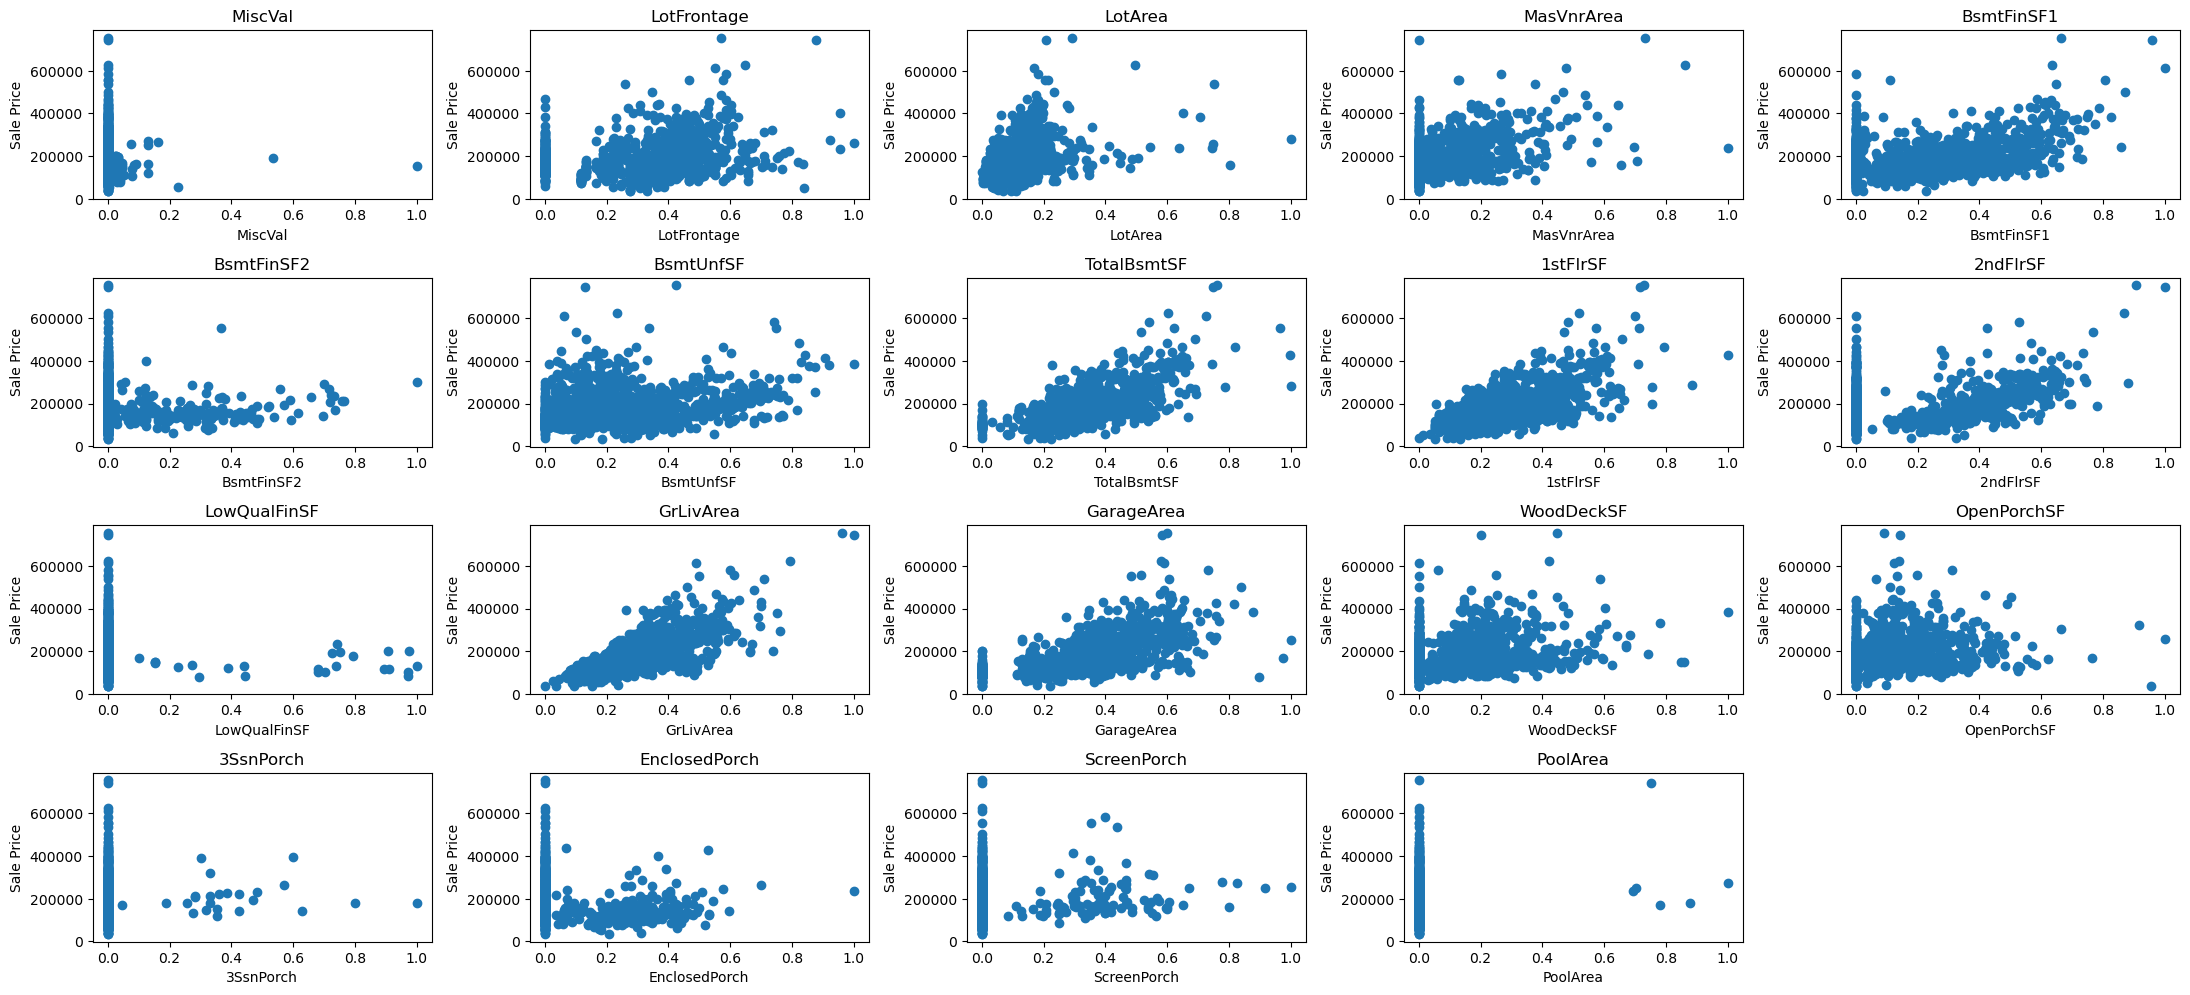

In [576]:
plt.figure(figsize = (22,22))
scaler = MinMaxScaler()
con_scaled = pd.DataFrame(scaler.fit_transform(continuous_features),columns=continuous_features.columns)
for i,col in enumerate(con_scaled):
    plt.subplot(9,5,i+1)
    
    x = con_scaled[col]
    y = train.SalePrice.values
    plt.scatter(x,y)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Sale Price")

    # Show the plot

plt.tight_layout()

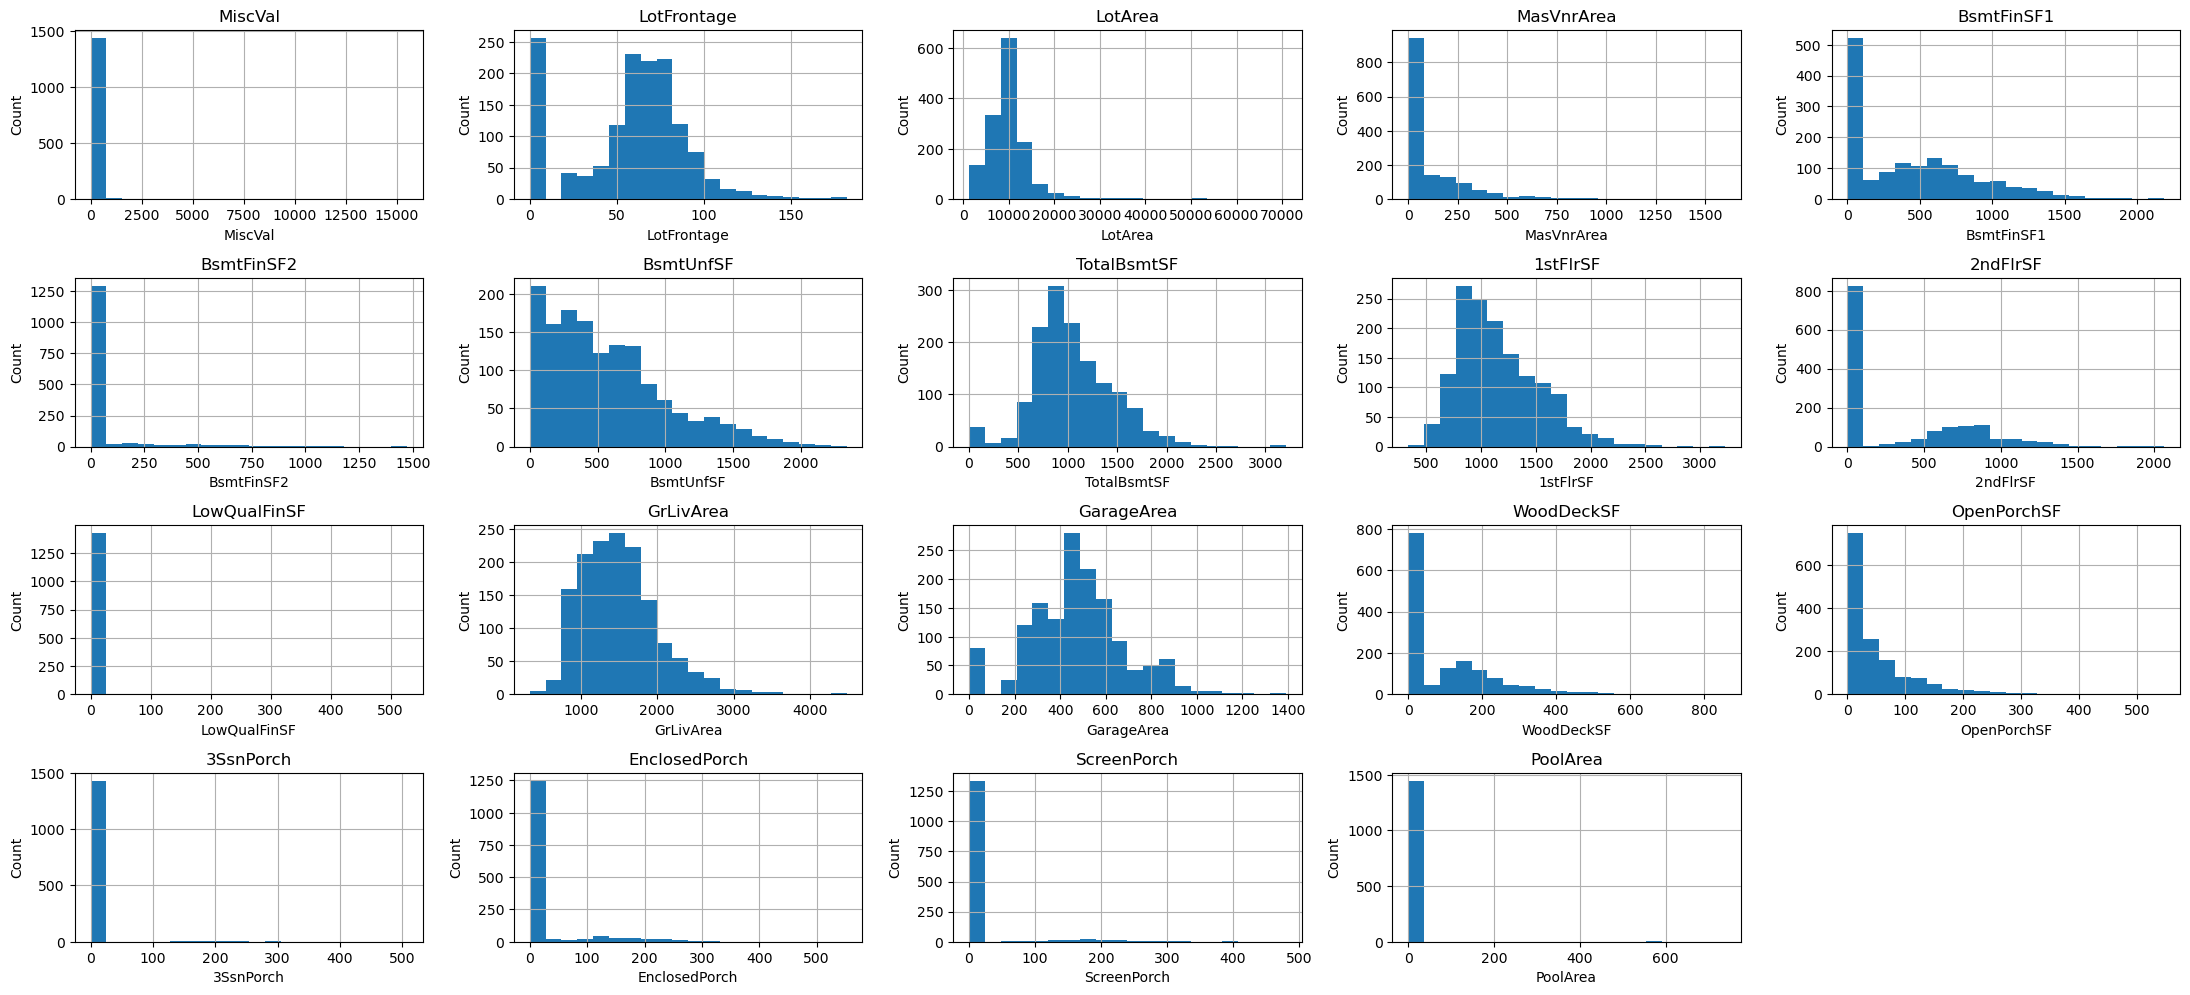

In [577]:
plt.figure(figsize = (22,22))
for i,col in enumerate(continuous_features):
    plt.subplot(9,5,i+1)
    
    continuous_features[col].hist(bins=20)
    # Add a title and labels to the x and y axes
    plt.title("{}".format(col))
    plt.xlabel(col)
    plt.ylabel("Count")

    # Show the plot

plt.tight_layout()

In [578]:


# Load your continuous features and target variable
target = train.SalePrice

# Train a random forest regressor
regressor = RandomForestRegressor(n_estimators=500)
regressor.fit(continuous_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(continuous_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

important = list(sorted_feature_importance.keys())

Feature: GrLivArea, Importance: 0.36398823256676544
Feature: GarageArea, Importance: 0.2031606274938449
Feature: TotalBsmtSF, Importance: 0.18520560105356676
Feature: BsmtFinSF1, Importance: 0.05603323202926543
Feature: 2ndFlrSF, Importance: 0.03679360747179954
Feature: 1stFlrSF, Importance: 0.03190272702113476
Feature: OpenPorchSF, Importance: 0.025819422341192905
Feature: LotArea, Importance: 0.022813380269057222
Feature: MasVnrArea, Importance: 0.022670487458928447
Feature: BsmtUnfSF, Importance: 0.015799853905154242
Feature: WoodDeckSF, Importance: 0.01357196990906801
Feature: LotFrontage, Importance: 0.012644728532034417
Feature: EnclosedPorch, Importance: 0.0035558665201489304
Feature: ScreenPorch, Importance: 0.002642806069098139
Feature: BsmtFinSF2, Importance: 0.0017354549613221512
Feature: 3SsnPorch, Importance: 0.0006762377990379157
Feature: MiscVal, Importance: 0.00036273776912421616
Feature: PoolArea, Importance: 0.0003233620010750091
Feature: LowQualFinSF, Importance: 0.0

In [579]:

# X = continuous_features
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# for i in range(1,30,3):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse = mean_squared_error(y_test, y_pred,squared=False)

#     print("RMSE:", int(mse),"Max_depth = ",i)

# Long loop looking for best continuous features

In [580]:

# for indx in range(3,11):
#     X = continuous_features[important[: indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3)



## So finally we would have imporant continuous features:

In [581]:
important_continuous_features = continuous_features[important[:8]]


## <inv> Finding Best Categorical Features

In [582]:

# One-hot encode the categorical features
categorical_features = pd.get_dummies(categorical_features)

# Train a random forest regressor
regressor = RandomForestRegressor()
regressor.fit(categorical_features, target)

# Obtain the feature importances
importances = regressor.feature_importances_

# Print the feature importances, sorted by importance
feature_importance = dict(zip(categorical_features.columns, importances))
sorted_feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

for feature, importance in sorted_feature_importance.items():
    print("Feature: {}, Importance: {}".format(feature, importance))

important = list(sorted_feature_importance.keys())

Feature: Foundation_PConc, Importance: 0.26137053666725346
Feature: RoofStyle_Hip, Importance: 0.07931815628093088
Feature: Neighborhood_NridgHt, Importance: 0.05143546824516792
Feature: Neighborhood_NoRidge, Importance: 0.03894256353760127
Feature: GarageType_Attchd, Importance: 0.03025176848451504
Feature: MasVnrType_Stone, Importance: 0.024602844100652325
Feature: GarageType_Detchd, Importance: 0.024145132215170905
Feature: MSSubClass_60, Importance: 0.023259526419961603
Feature: BldgType_1Fam, Importance: 0.018242982877588274
Feature: Neighborhood_Crawfor, Importance: 0.017647469286632095
Feature: MasVnrType_None, Importance: 0.016697739047184357
Feature: RoofMatl_WdShngl, Importance: 0.015348153149002782
Feature: MSZoning_RL, Importance: 0.014229048046884291
Feature: RoofMatl_CompShg, Importance: 0.014033164389837888
Feature: Neighborhood_StoneBr, Importance: 0.012651613353256732
Feature: MSZoning_RM, Importance: 0.011148060186936705
Feature: LotConfig_CulDSac, Importance: 0.01013

In [583]:
# for indx in range(14,20,1):
#     X = categorical_features[important[: indx]]
#     y = train.SalePrice
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     mse = []
#     for i in range(1,30,3):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", np.min(mse), " Depth = ", 1 + np.argmin(mse)*3, ' N_features = ', indx)

## And finally we have:

In [584]:
important_categorical_features = categorical_features[important[:17]]


## Checking RMSE with/without discrete features

#### <ins>With BedroomAbvGr

In [585]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['BedroomAbvGr'] = discrete_features['BedroomAbvGr']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins>With Year sold

In [586]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['YrSold'] = discrete_features['YrSold']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> With KitchenAbvGr

In [587]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['KitchenAbvGr'] = discrete_features['KitchenAbvGr']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> With BsmtHalfBath

In [588]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# X['BsmtHalfBath'] = discrete_features['BsmtHalfBath']
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


    

#### <ins> Without Discrete features

In [589]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


#### Seems like adding any discrete feature reduces the RMSE

### Check correlations of remaining features

### Very long loop searching for features that lower RMSE

#### results:
 Index(['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearRemodAdd', 'FullBath',
       'FireplaceQu', 'YearBuilt', 'GarageYrBlt', 'BsmtExposure',
       'BsmtFullBath', 'Fireplaces', 'BsmtQual', 'BsmtFinType1',
       'GarageFinish'],
      dtype='object')

In [590]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# columns = X.columns
# keep = []
# for col in columns:
#     X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
#     y = train.SalePrice
#     X.drop( [col],axis=1,inplace=True)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
#     mse = []
#     for i in range(7,25,1):
#         model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#         # fit the model on the training data
#         model.fit(X_train, y_train)

#         # make predictions on the test data
#         y_pred = model.predict(X_test)

#         # calculate the mean squared error of the predictions
#         mse.append(mean_squared_error(y_test, y_pred,squared=False))

#     print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7, ' Column Dropped = ',col)
#     if int(np.min(mse)) > 30200:
#         keep.append(col)

In [591]:
keep = ['OverallQual', 'GarageCars', 'TotRmsAbvGrd', 'YearRemodAdd', 'FullBath',
       'FireplaceQu', 'YearBuilt', 'GarageYrBlt', 'BsmtExposure',
       'BsmtFullBath', 'Fireplaces', 'BsmtFinType1',
       'GarageFinish']

Find best model

In [592]:
# X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
# # X['area_rooms_ratio'] = X.LotArea / X.TotRmsAbvGrd
# y = train.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)


Test best model

In [593]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
y = train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = RandomForestRegressor(n_estimators=500,max_depth=12,random_state=0)

# fit the model on the training data
model.fit(X_train, y_train)

# make predictions on the test data
y_pred = model.predict(X_test)

# calculate the mean squared error of the predictions
mean_squared_error(y_test, y_pred,squared=False)

23417.974462422382

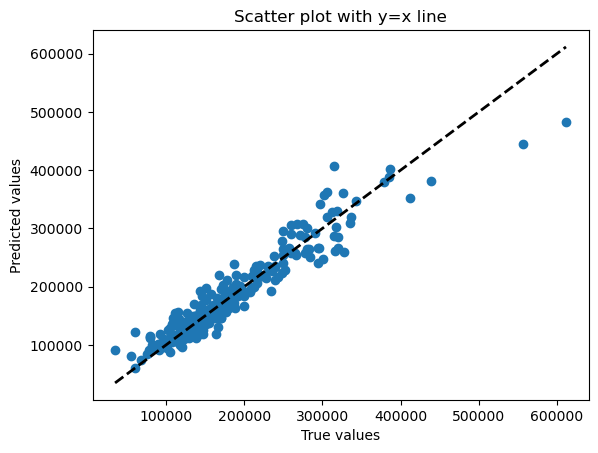

In [594]:
plt.scatter( y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.title('Scatter plot with y=x line')
plt.show()


In [595]:
X_test['SalePrice'] = y_test
X_test['Prediction'] = np.int64(y_pred)
X_test['Error'] = np.int64(np.abs(y_test - y_pred))

wrong_index = X_test[X_test.SalePrice > 300000].sort_values('Error',ascending=False).iloc[:15].index

1. Most have above average rooms
2. Most have above average Fireplaces
3. Except for the second most wrong, all are above average LotArea 
4. Most have big difference between OverallQual and OverallCond - Try creating a feature OverallQual - OverallCond - Didnt do much
5. Mostly above average year built

## GOOD FEATURES FOUND IN EXPLORATIONS
1. X.LotArea / X.TotRmsAbvGrd a very slight improvment on validation

In [596]:
X = pd.concat([important_continuous_features,important_ordinal_features,important_categorical_features],axis=1)
indx = X.index
# X['QualCondRatio'] = train.loc[indx,'OverallQual'] * train.loc[indx,'OverallCond']
y = train.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# mse = []
# for i in range(7,25,1):
#     model = RandomForestRegressor(n_estimators=500,max_depth=i,random_state=0)

#     # fit the model on the training data
#     model.fit(X_train, y_train)

#     # make predictions on the test data
#     y_pred = model.predict(X_test)

#     # calculate the mean squared error of the predictions
#     mse.append(mean_squared_error(y_test, y_pred,squared=False))

# print("RMSE:", int(np.min(mse)),"Max_depth = ",np.argmin(mse) + 7)

### Model with best hyperparameters

In [597]:

best_RF = RandomForestRegressor(n_estimators=500,max_depth=15,random_state=0)

# fit the model on the training data
best_RF.fit(X_train, y_train)

# make predictions on the test data
y_pred = best_RF.predict(X_test)

# calculate the mean squared error of the predictions
mean_squared_error(y_test, y_pred,squared=False)

23396.924825511578

### GridSearch for XGBoost

In [598]:

# dtrain = xgb.DMatrix(data=X_train, label=y_train)
# dtest = xgb.DMatrix(data=X_test, label=y_test)

# # Define the XGBoost parameters to search
# params = {'objective': ['reg:squarederror'],
#           'eval_metric': ['mae'],
#           'n_jobs': [-1],
#           'tree_method': ['auto'],
#           'max_depth': [3, 5, 7, 9,15],
#           'min_child_weight': [1, 3, 5],
#           'gamma': [0, 0.1, 0.2, 0.3],
#           'subsample': [0.5, 0.7, 0.9],
#           'colsample_bytree': [0.5, 0.7, 0.9],
#           'learning_rate': [0.01, 0.05, 0.1, 0.2]}

# # Perform the grid search
# grid_search = GridSearchCV(xgb.XGBRegressor(), params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Train the XGBoost model using the best parameters
# model = xgb.train(grid_search.best_params_, dtrain, num_boost_round=500)

# # Make predictions on the test data
# y_pred = model.predict(dtest)

# # Calculate the mean squared error of the predictions
# print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))


### Scatter plot of true vs predictions

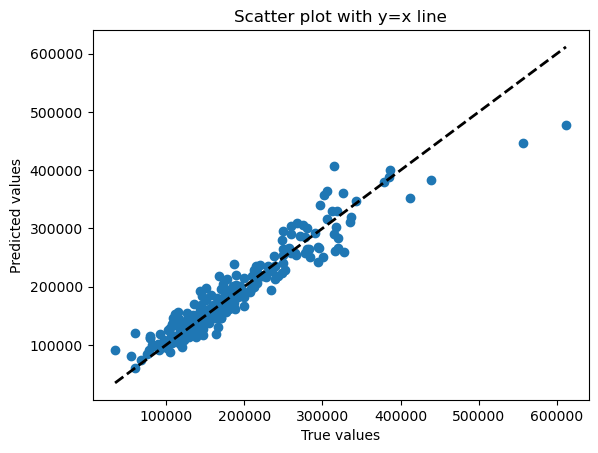

In [599]:
plt.scatter( y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.title('Scatter plot with y=x line')
plt.show()


## Notes from kaggle note book:
1. Uni-modal, skewed distributions could potentially be log transformed: LotFrontage, LotArea, 1stFlrSF, GrLivArea, OpenPorchSF
2. Not yet clear what to do with LotFrontage missing values. Simple imputation with median? LotFrontage correlation with Neigborhood? Try Median instead of neighborhood
3. Outliers 

### XGBoost model 

In [600]:
import xgboost as xgb


# Initialize the XGBoost regressor
model = xgb.XGBRegressor(n_estimators=500, max_depth=12, random_state=0)

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the mean squared error of the predictions
mean_squared_error(y_test, y_pred, squared=False)


23702.07045303343

### GridSearch for XGBRegressor

In [601]:

# Define the parameter grid to search
# param_grid = {'n_estimators': [100, 500, 1000],
#               'max_depth': [3, 5, 7, 12]}

# # Initialize the XGBoost regressor
# model = xgb.XGBRegressor()

# # Perform grid search
# grid_search = GridSearchCV(model, param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# # Make predictions on the test data using the best estimator
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# # Calculate the mean squared error of the predictions
# mean_squared_error(y_test, y_pred, squared=False)


## <ins> Removing outliers
1. best_score without : 25457
2. best_score when removing outliers: 23553

# <ins> Handling Test data

### Remove columns that are not in the final train columns

In [602]:
test['QualCondRatio'] = test.OverallQual - test.OverallCond
final_cols = []
for col in X.columns:
    if '_' in col:
        final_cols.append(col.split(sep='_')[0])
    else:
        final_cols.append(col)

final_cols = list(set(final_cols))
test = test.loc[:,final_cols]

### Which columns have missing values?

In [603]:

# Get a Boolean DataFrame indicating missing values
missing_values = test.isna().any()

# Get the columns that have missing values

# Get the count of missing values per column
missing_values_count = test.isna().sum()

# Get the columns that have missing values and sort by number of missing values
columns_with_missing_values = missing_values_count[missing_values].sort_values().index.tolist()
for column in columns_with_missing_values:
    count = missing_values_count[column]
    print(f'"{column}" has {count} missing value(s), dtype = {test[column].dtype}')

"GarageArea" has 1 missing value(s), dtype = float64
"GarageCars" has 1 missing value(s), dtype = float64
"TotalBsmtSF" has 1 missing value(s), dtype = float64
"BsmtFinSF1" has 1 missing value(s), dtype = float64
"BsmtFullBath" has 2 missing value(s), dtype = float64
"MSZoning" has 4 missing value(s), dtype = object
"MasVnrType" has 16 missing value(s), dtype = object
"BsmtFinType1" has 42 missing value(s), dtype = object
"BsmtExposure" has 44 missing value(s), dtype = object
"BsmtQual" has 44 missing value(s), dtype = object
"GarageType" has 76 missing value(s), dtype = object
"GarageFinish" has 78 missing value(s), dtype = object
"GarageYrBlt" has 78 missing value(s), dtype = float64
"FireplaceQu" has 730 missing value(s), dtype = object


### Impute like train

In [604]:
# numeric
test.GarageArea.fillna(0,inplace=True)
test.GarageCars.fillna(0,inplace=True)
test.TotalBsmtSF.fillna(0,inplace=True)
test.BsmtFinSF1.fillna(0,inplace=True)
test.BsmtFullBath.fillna(0,inplace=True)
test.GarageYrBlt.fillna(0,inplace=True)
# test.MasVnrArea.fillna(0,inplace=True)
# categorical
test.FireplaceQu.fillna("Na",inplace=True)
test.GarageFinish.fillna("Na",inplace=True)
test.GarageType.fillna("Na",inplace=True)
test.BsmtQual.fillna("Na",inplace=True)
test.BsmtExposure.fillna("Na",inplace=True)
test.BsmtFinType1.fillna("Na",inplace=True)
test.MasVnrType.fillna("Na",inplace=True)
# MSZoning imputed with mode of neighborhood
test.loc[455,['MSZoning']] = 'RM'
test.loc[756,['MSZoning']] = 'RM'
test.loc[790,['MSZoning']] = 'RM'
test.loc[1444,['MSZoning']] = 'RL'


### Change MSSubclass to categorical and assign values to ordinal columns

In [605]:
columns = ['ExterCond','ExterQual', 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual']

mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'Na': 0,
    'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,
    'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
    'Typ': 7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0,
    'Fin': 3, 'RFn': 2, 'Unf': 1}


for col in columns:
    if col in test.columns:
        test[col] = test[col].map(mapping)


test['MSSubClass'] = test['MSSubClass'].astype(str)


### one-hot-encode and remove columns not found in train again

In [606]:
test = pd.get_dummies(test)
test = test.loc[:,X.columns]

### Align

In [607]:
X, test = X.align(test, join='left', axis=1)

# <ins> Predicting test

# Random Forest - score: 0.19

In [608]:
# make predictions which we will submit. 
test_preds = best_RF.predict(test)

# The lines below shows you how to save your data in the format needed to score it in the competition
# Reminder: predictions are in log(SalePrice). Need to inverse-transform.
output = pd.DataFrame({'Id': test_id,
                       'SalePrice': test_preds})

output.to_csv('RF_submission.csv', index=False)